# 2) Networks

#### <u>Author:</u> Matthew McDermott (_U.C. Berkeley / Lawerence Berkeley National Laboratory_)
<u>Last Updated:</u> 10/18/23
$$\require{mhchem}$$
This notebook serves as a walkthrough for **reaction network construction and pathfinding analysis**. If you haven't first explored the enumerator notebook `1_enumerators.ipynb`, we strongly recommend starting there, as it will cover the foundation for how reaction networks are constructed. 

The code provided in this notebook is an updated walkthrough of a case study (YMnO$_3$ synthesis) in the manuscript below. The current version of the `reaction-network` package contains similar functionality as what was originally released with the manuscript; however, much of the code has been drastically improved. If you arrived here looking for the specific results that went into the manuscript, then look at the archived demo notebook in the _archived_ folder or an older Release of the package on Github.

Lastly, if you use this code or Python package in your work, please consider citing the following paper:

    McDermott, M. J., Dwaraknath, S. S., and Persson, K. A. (2021). A graph-based network for predicting chemical reaction pathways in solid-state materials synthesis. Nature Communications, 12(1). https://doi.org/10.1038/s41467-021-23339-x

**Warning**: the specific results shown here are subject to change with future updates to Materials Project data and/or the reaction-network code.

## 1. Imports

We first import the classes and functions we will need throughout the notebook. If you get an error importing any of these, please make sure you run:

`pip install -U reaction-network` 

`pip install -U mp-api` 

in your terminal to ensure that you have successfully installed the package/dependencies. You may need to restart and reconfigure your Jupyter kernel as well.

In [1]:

from mp_api.client import MPRester

from rxn_network.costs.functions import Softplus
from rxn_network.entries.entry_set import GibbsEntrySet
from rxn_network.enumerators.basic import BasicEnumerator
from rxn_network.network.network import ReactionNetwork
from rxn_network.network.visualize import plot_network
from rxn_network.pathways.solver import PathwaySolver
from rxn_network.reactions.computed import ComputedReaction

# this is useful if you are editing the rxn_network package locally!
%load_ext autoreload
%autoreload 2

## Case Study: YMnO3 assisted metathesis
### Background

We will be using the assisted metathesis synthesis of YMnO$_3$ as a case study for the reaction network code. This is the first example discussed in the original manuscript. The assisted metathesis reaction reported by [Todd & Neilson (JACS, 2019)](https://pubs.acs.org/doi/full/10.1021/jacs.8b10123) corresponds to a net reaction of:

$$\ce{Mn2O3 + 2\ YCl3 + 3\ Li2CO3 -> 2\ YMnO3 + 6\ LiCl + 3\ CO2}$$

This is a powder reaction involving three solid precursors, which suggests there might be some intermediate reactions here worth identifying. This is seen experimentally. 

In the paper, they report a reaction pathway involving the formation of key intermediates LiMnO$_2$ and YOCl. These react to form YMnO$_3$ product and LiCl byproduct. The pathway seen experimentally looks something like this:

$$\ce{Li2CO3 + Mn2O3 -> 2\ LiMnO2 + CO2}$$
$$\ce{YCl3 + Li2CO3 -> YOCl + 2\ LiCl + CO2}$$
$$\ce{LiMnO2 + YOCl -> YMnO3 + LiCl}$$

Due to carbonate decomposition, $\ce{Li2O}$ may exist in place of $\ce{Li2CO3}$.

## 2. Acquiring thermodynamic data from the Materials Project

As we did in the previous notebook, we first acquire entries for phases in the system of interest (Y-Mn-O-Li-Cl-C). We do this by querying the Materials Project (MP), a computed materials database containing calculations for over 150,000 materials:

In [2]:
# insert your Materials Project API key in the parentheses below, or configure elsewhere. See mp-api for more info.

with MPRester() as mpr:
    entries = mpr.get_entries_in_chemsys("Y-Mn-O-Li-Cl-C")

Retrieving ThermoDoc documents:   0%|          | 0/919 [00:00<?, ?it/s]

Previously we showed that the `GibbsEntrySet` class allows us to automatically convert `ComputedStructureEntry` objects downloaded from the MP database into `GibbsComputedEntry` objects, where DFT-calculated energies have been converted to machine learning (ML)-estimated equivalent values of the Gibbs free energies of formation, $\Delta G_f$, for all entries at the specified temperature. This also mixes in experimental thermochemistry data (e.g., from NIST-JANAF).

For more information, check out the citation in the documentation for `GibbsComputedEntry`.

In [3]:
temp = 923  # synthesis temperature of interest in Kelvin (650 ºC)
entry_set = GibbsEntrySet.from_computed_entries(entries, temp)

We can use the `filter_by_stability()` function to automatically remove metastable entries above a certain energy threshold. This will dramatically decrease the combinatorial complexity of our space.

In [4]:
filtered_entries = entry_set.filter_by_stability(0.00)  # use only stable phases (i.e., 0 eV/atom threshold)

print(f"{len(entry_set)} (unfiltered) -> {len(filtered_entries)} (filtered)")

798 (unfiltered) -> 45 (filtered)


In this case, we remove all entries which are unstable (above an energy cutoff of 0.0 meV/atom). Typically, you will want this number to be greater than zero. A good range is somewhere between 0.0 to 0.100 eV/atom. See [this paper](https://www.science.org/doi/10.1126/sciadv.aaq0148) for more information on energy thresholds for metastability.

## 3. Building the reaction network

To build a reaction network, we need to first enumerate a set of reactions. Please see the first notebook (`1_enumerators.ipynb`) for more information on reaction enumeration.

We will use a BasicEnumerator to get all reactions in the Y-Mn-O-C-Li-Cl system up to <=2 reactants or products:

In [5]:
be = BasicEnumerator()

In [6]:
rxns = be.enumerate(filtered_entries)  # this will take a few seconds

2023-10-18 10:57:56,119 INFO rxn_network.utils.ray Ray is not initialized. Checking for existing cluster...
2023-10-18 10:57:56,120 INFO rxn_network.utils.ray Could not identify existing Ray instance. Creating a new one...


2023-10-18 10:57:57,919	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


2023-10-18 10:57:58,562 INFO rxn_network.utils.ray HOST: matts-mbp.lan.vpn-dhcp.lbl.gov, Num CPUs: 12.0, Total Memory: 31099111015.0


Enumerating reactions (BasicEnumerator): 100%|██| 11/11 [00:02<00:00,  4.65it/s]


We identified a few thousand reactions:

In [7]:
print(len(rxns))

2774


Finally, before we can create a reaction network, we must specify how to assign weights to the edge of the network. 

The "cost function" is a monotonic function used to assign edge weights. In this case, we will use the softplus function (as in the original paper), assigned with temperature scaling of $T=650$ ºC (923 K) with default arguments. This automatically converts the `energy_per_atom` of the reactions to positive cost values:

In [8]:
cf = Softplus(temp=temp)

For example, here is how it transforms the energies to costs for a few reactions:

In [9]:
for idx, r in enumerate(rxns):
    print(r)
    print("     Energy/cost:", round(r.energy_per_atom, 4), "eV/atom ->", round(cf.evaluate(r), 4), "au")
    if idx >= 3:
        break

0.08333 YMn12 + LiYO2 -> LiMnO2 + 1.083 Y
     Energy/cost: 0.8901 eV/atom -> 0.5425 au
LiMnO2 + 1.083 Y -> 0.08333 YMn12 + LiYO2
     Energy/cost: -0.8901 eV/atom -> 0.1146 au
LiMnO2 + 2 LiYO2 -> Li3MnO3 + Y2O3
     Energy/cost: -0.0005 eV/atom -> 0.259 au
Li3MnO3 + Y2O3 -> LiMnO2 + 2 LiYO2
     Energy/cost: 0.0005 eV/atom -> 0.2592 au


We are now ready to build a reaction network from our reactions. To do this, we first initialize a `ReactionNetwork` object:

In [10]:
rn = ReactionNetwork(rxns, cf)

Initialization does not build the network graph. To do so, we must call the `.build()` function, which runs in-place:

In [11]:
rn.build()

2023-10-18 10:58:01,348 INFO rxn_network.network.network Building graph from reactions...


100%|█████████████████████████████████████| 2774/2774 [00:01<00:00, 1943.02it/s]


2023-10-18 10:58:03,027 INFO rxn_network.network.network Built graph with 1160 nodes and 3354 edges


This should have completed within a few seconds. A weighted graph object is built using the `rustworkx` and stored under the `graph` attribute of the reaction network object.

We can access this graph object by using the `graph` attribute:

In [12]:
rn.graph

<rxn_network.network.base.Graph object at 0x2b6b257d0> with 1160 nodes and 3354 edges

**Plotting:** There are many ways to plot reaction networks. The easiest is to use the built in `mpl_draw` function from rustworkx, which has been provided in a wrapper function.

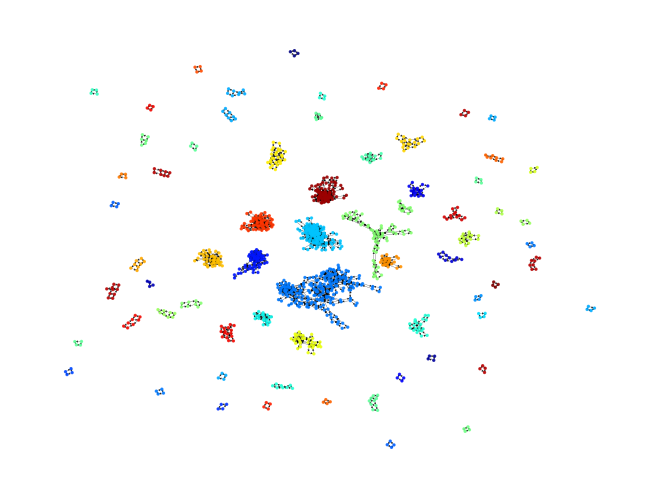

In [13]:
plot_network(rn.graph);

You'll notice that at this stage, the reaction network graph is a collection of "sub"-networks, i.e. a collection of smaller reaction networks for smaller chemical subsystems. This configuration will change once we set up for pathfinding in the next section.

Alternative ways of plotting networks will not be covered in this notebook; however, any graph plotting tool that takes in Python network objects should theoretically work with the right customization settings.

## 4. Identifying reaction pathways using pathfinding and balancing/solving

To identify reaction pathways, we must first set the starting point (precursor phases) and ending point (target) phase. 

This will automatically build all the required "zero-cost" edges which connect the different chemical subsystems. Please see the original manuscript for more details on how this is completed.

In summary, zero-cost "loopback" edges are drawn from a product node to any reactant node that contains a subset of the set consisting of the {precursors + products} phases. 

In [14]:
rn.set_precursors(["Li2CO3", "Mn2O3", "YCl3"])

We can only set one target node at a time. However, this does not prohibit finding paths to multiple targets (see a few cells below).

In [15]:
rn.set_target("YMnO3")

We can see how this changes the network by re-drawing it:

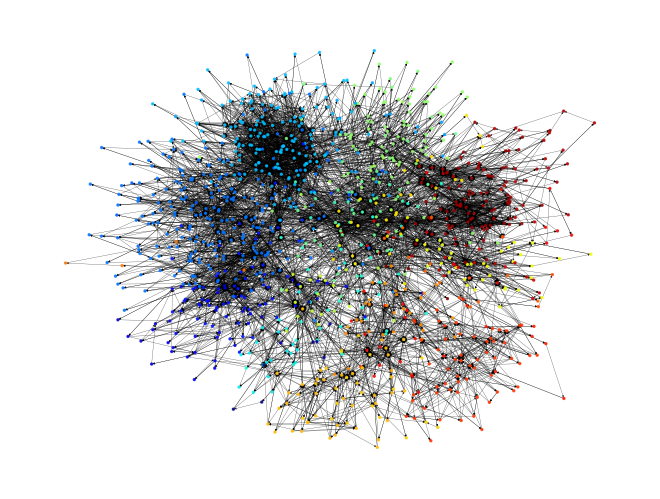

In [16]:
plot_network(rn.graph);

You should now see that the chemical subsystems have been linked together with the zero-cost edges that we just described. This will probably look messy! This is where pathfinding comes in handy.

To get reaction pathways, we simply call the `find_pathways()` method. This automatically handles finding pathways to multiple targets, by calling the internal shortest paths method. The _k_ parameter specifies the number of shortest paths to find to each target. This uses Yen's k-shortest paths algorithm. Here, we use $k=5$ paths per target, however you may want to add more (e.g., 10 or even 15).

In [17]:
paths = rn.find_pathways(["YMnO3", "LiCl", "CO2"], k=5)

Paths to YMnO3 

--------------------------------------- 

3 Li2CO3 + 2 Mn2O3 -> Li3MnO3 + 3 LiMnCO4 (dG = 0.013 eV/atom) 
Li3MnO3 + YCl3 -> YMnO3 + 3 LiCl (dG = -0.23 eV/atom) 
Total Cost: 0.473 

1.5 Li2CO3 + 0.5 Mn2O3 -> Li3MnO3 + 1.5 CO2 (dG = 0.078 eV/atom) 
Li3MnO3 + YCl3 -> YMnO3 + 3 LiCl (dG = -0.23 eV/atom) 
Total Cost: 0.489 

Mn2O3 + 0.2222 YCl3 -> 0.2222 Mn8Cl3O10 + 0.1111 Y2Mn2O7 (dG = -0.015 eV/atom) 
Y2Mn2O7 + Mn2O3 -> 2 MnO2 + 2 YMnO3 (dG = 0.004 eV/atom) 
Total Cost: 0.516 

Mn2O3 + 0.2222 YCl3 -> 0.2222 Mn8Cl3O10 + 0.1111 Y2Mn2O7 (dG = -0.015 eV/atom) 
0.5 Y2Mn2O7 -> YMnO3 + 0.25 O2 (dG = 0.036 eV/atom) 
Total Cost: 0.523 

Mn2O3 + 0.2 YCl3 -> 0.2 Mn8Cl3O10 + 0.2 YMn2O5 (dG = -0.026 eV/atom) 
YMn2O5 -> MnO2 + YMnO3 (dG = 0.048 eV/atom) 
Total Cost: 0.523 

Paths to LiCl 

--------------------------------------- 

2 Li2CO3 + Mn2O3 -> Li2O + 2 LiMnCO4 (dG = 0.036 eV/atom) 
0.5 Li2O + 0.3333 YCl3 -> LiCl + 0.1667 Y2O3 (dG = -0.322 eV/atom) 
Total Cost: 0.462 

2 Li2CO3 +

The output of this method is a `PathwaySet` object. The set of pathways is composed of individual `BasicPathway` objects. 

In [18]:
example_path = paths.paths[0]
print(example_path)

3 Li2CO3 + 2 Mn2O3 -> Li3MnO3 + 3 LiMnCO4 (dG = 0.013 eV/atom) 
Li3MnO3 + YCl3 -> YMnO3 + 3 LiCl (dG = -0.23 eV/atom) 
Total Cost: 0.473


**Note: these objects contain a list of reactions and associated costs, but the actual pathway is typically not balanced (i.e. some intermediates are made and never consumed).**

This also means that the reactions you see above do not necessarily include all reactants, nor do they form all desired products. They are simply a series of reactions extracted from the reaction network that may be encountered as the system traverses phase space on its way from precursor(s) to target(s).

To get the balanced reaction pathways, we can use the `PathwaySolver` class. This class takes a `PathwaySet`, the set of entries used in the reaction network, and a cost function. It can be used to solve for balanced pathways given a net reaction. First we initialize the class:

In [19]:
ps = PathwaySolver(paths, rn.entries, cf)

To balance the pathways, we must provide a net reaction representing the total conversion of precursors to final products. This corresponds to the assisted metathesis reaction we defined in the beginning. 

Note: for your own systems where you do not know a net reaction _a priori_, it is logical to make the net reaction's products equal to the set of phases which minimize free energy at the total composition of your system. To do this, one can make a compositional phase diagram and determine the net reaction from there (this is not covered in the notebook here).

We initialize our net reaction here as a `ComputedReaction` object from the corresponding entries. This can be done using the `balance()` constructor and should match the stoichiometry of the overall reaction equation at the top of this notebook.

In [20]:
product_entries = []
for i in ["YMnO3","LiCl","CO2"]:
    product_entries.append(rn.entries.get_min_entry_by_formula(i))

net_rxn = ComputedReaction.balance(rn.precursors, product_entries)
net_rxn

1.5 Li2CO3 + 0.5 Mn2O3 + YCl3 -> YMnO3 + 3 LiCl + 1.5 CO2

Finally, we provide the net reaction to the `PathwaySolver` object. The _intermediate_rxn_energy_cutoff_ helps to limit which intermediate reactions are considered (this can substantially decrease the combinatorial complexity), and the _filter_interdependent_ flag verifies that suggested pathways do not contain interdependent reactions. An interdependent pathway is one where 1) the reactants of reaction A depend on the products of the reaction B, and 2) the reactants of reaction B depend on the products of reaction A.

**WARNING**: Even though the code for pathway solving been optimized and parallelized, this is often the most time-intensive step in the reaction network analysis. Consider limiting the value of the maximum number of combos to 5 or less, as well as the value of the intermediate reaction energy cutoff (i.e. < 0.0).

In [21]:
balanced_paths = ps.solve(net_rxn, max_num_combos=4,
                          intermediate_rxn_energy_cutoff=0.0,
                          use_minimize_enumerator=False,
                          filter_interdependent=True)

2023-10-18 10:58:18,834 INFO rxn_network.pathways.solver Net reaction: 1.5 Li2CO3 + 0.5 Mn2O3 + YCl3 -> YMnO3 + 3 LiCl + 1.5 CO2 

2023-10-18 10:58:18,834 INFO rxn_network.pathways.solver Identifying reactions between intermediates...


Enumerating reactions (BasicEnumerator): 100%|████| 2/2 [00:00<00:00, 10.92it/s]
Filtering duplicates: 0it [00:00, ?it/s]

2023-10-18 10:58:19,073 INFO rxn_network.pathways.solver Found 48 intermediate reactions! 




Filtering duplicates: 100%|█████████████████████| 2/2 [00:00<00:00, 1620.67it/s]


2023-10-18 10:58:19,372 INFO rxn_network.pathways.solver Building comp matrices...


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 10.56it/s]

2023-10-18 10:58:20,131 INFO rxn_network.pathways.solver Comp matrices done...



PathwaySolver (Batch 1/1): 100%|██████████████████| 3/3 [00:01<00:00,  1.58it/s]


We can now print the suggested, balanced reaction pathways. These are ordered by an average cost of the total pathway, which is effectively a sum of the indiviudal reaction step costs weighted by their multiplicities (how much of each is required to balance the pathway).

In [22]:
for idx, path in enumerate(balanced_paths):
    print(f"Path {idx+1}", "\n")
    print(path)
    print("\n")

Path 1 

0.5 Mn2O3 + 1.5 Li2CO3 -> 1.5 CO2 + Li3MnO3 (dG = 0.078 eV/atom) 
0.3333 YCl3 + 0.3333 Li3MnO3 -> 0.3333 YMnO3 + LiCl (dG = -0.23 eV/atom) 
Average Cost: 0.228


Path 2 

0.3333 YCl3 + 0.5 Li2O -> 0.1667 Y2O3 + LiCl (dG = -0.322 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.161 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Average Cost: 0.23


Path 3 

0.5 Mn2O3 + 0.5 Li2CO3 -> 0.5 CO2 + LiMnO2 (dG = 0.006 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.161 eV/atom) 
0.5 YCl3 + 0.5 Li2O -> 0.5 YClO + LiCl (dG = -0.294 eV/atom) 
YClO + LiMnO2 -> YMnO3 + LiCl (dG = -0.083 eV/atom) 
Average Cost: 0.24


Path 4 

Li2CO3 -> CO2 + Li2O (dG = 0.161 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
0.5 YCl3 + 0.5 Li2O -> 0.5 YClO + LiCl (dG = -0.294 eV/atom) 
2 YClO + Li2O -> Y2O3 + 2 LiCl (dG = -0.152 eV/atom) 
Average Cost: 0.24


Path 5 

0.5 YCl3 + Li2O -> 1.5 LiCl + 0.5 LiYO2 (dG = -0.279 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.161 eV/atom) 
0.6667 Mn2O3 + LiYO2 -> YMnO3 + 0.333

**Our reaction pathway analysis suggests seven possible balanced pathways that are very close in average cost.** A reaction pathway passing through binary oxides is reflected in Pathway #1 and #6, and the experimentally observed metathesis pathway is reflected in Pathway #5. Repeating this analysis at different temperatures shows the ordering of the pathways is sensitive to small differences in energies.

Many times, the suggested pathways will include hypothetical (never-before-synthesized) materials. Notably, Pathways 2 and 3 feature $\ce{Li3MnO3}$. If one is sure a phase is not synthesizable (or would not likely be observed, these pathawys can be filtered out). However, enforcing manual filters / biases poses some risk and reduces the potential impact of the predictions.

**The top-ranked pathway using average cost may not necessarily match what is experimentally observed**; if a certain phase is inaccessible (perhaps due to kinetic reasons), this may rule out a top pathway from being physically possible. One should also explore different pathway ranking approaches.

## 5. Running networks with jobflow

As was demonstrated in the previous notebook on reaction enumeration, the _reaction-network_ package includes workflows implemented using _jobflow_. 

Below we will briefly demonstrate constructing and running the same analysis as above using the `NetworkFlowMaker`. Reminder: you must have properly configured your jobflow settings in order for this to work. Read more here: https://materialsproject.github.io/jobflow/

**WARNING**: if you have set this up such that your `JobStore` lives on a MongoDB (or similar) database, make sure you specify the additional databases `rxns`, `entries`, `paths`, and `network` in your *jobflow.yaml* file!

In [23]:
from jobflow.managers.local import run_locally

from rxn_network.flows.core import NetworkFlowMaker
from rxn_network.jobs.core import NetworkMaker, PathwaySolverMaker

In [24]:
precursors=["YCl3", "Mn2O3", "Li2CO3"]
targets=["YMnO3", "LiCl", "CO2"]
k=5
cf = Softplus(temp=923) # Kelvin

network_maker = NetworkMaker(cost_function=cf, precursors=precursors, targets=targets, calculate_pathways=5)
solver_maker = PathwaySolverMaker(cost_function=cf, precursors=precursors, targets=targets)

In [25]:
flow = NetworkFlowMaker(network_maker=network_maker,
                        solver_maker=solver_maker,
                        use_minimize_enumerators=False).make(precursors=precursors,
                                                             targets=targets,
                                                             entries=filtered_entries)

<module 'matplotlib.pyplot' from '/Users/mcdermott/miniconda3/envs/rn_dev/lib/python3.10/site-packages/matplotlib/pyplot.py'>

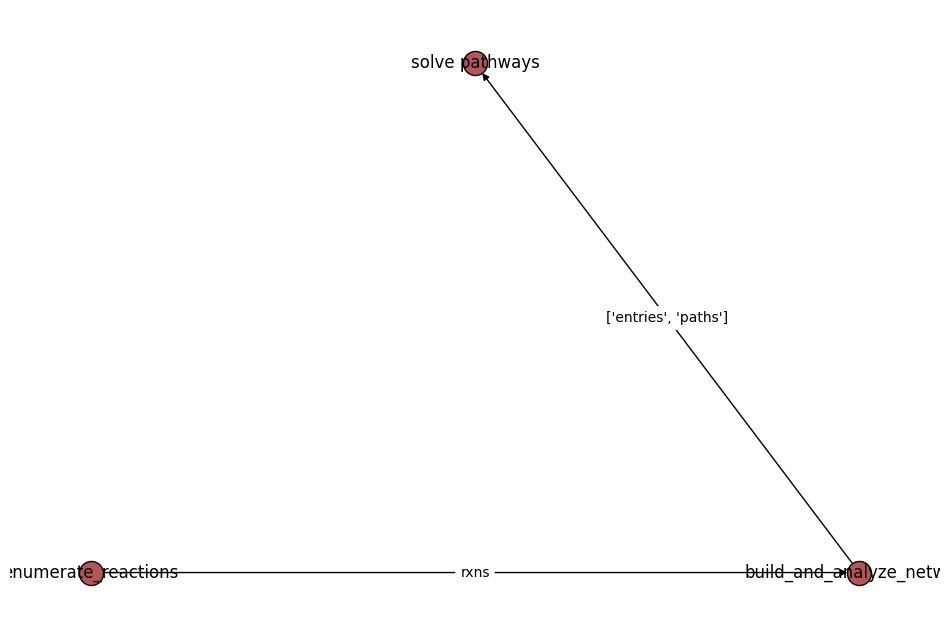

In [26]:
flow.draw_graph()

In [27]:
output = run_locally(flow)

2023-10-18 10:58:22,706 INFO Started executing jobs locally
2023-10-18 10:58:22,711 INFO Starting job - enumerate_reactions (ef8c3be9-6ee7-4d7a-be6b-337d124d4d8b)
2023-10-18 10:58:22,716 INFO rxn_network.jobs.core Running enumerators...
2023-10-18 10:58:22,716 INFO rxn_network.enumerators.utils Running BasicEnumerator


Enumerating reactions (BasicEnumerator): 100%|██| 11/11 [00:00<00:00, 12.48it/s]

2023-10-18 10:58:23,729 INFO rxn_network.enumerators.utils Adding 2774 reactions to reaction set
2023-10-18 10:58:23,729 INFO rxn_network.enumerators.utils Completed reaction enumeration. Filtering duplicates...



Filtering duplicates: 100%|███████████████████| 21/21 [00:00<00:00, 1211.01it/s]

2023-10-18 10:58:23,758 INFO rxn_network.enumerators.utils Completed duplicate filtering.
2023-10-18 10:58:23,758 INFO rxn_network.jobs.core Building task document...


2023-10-18 10:58:24,850 INFO Finished job - enumerate_reactions (ef8c3be9-6ee7-4d7a-be6b-337d124d4d8b)
2023-10-18 10:58:24,855 INFO Starting job - build_and_analyze_network (4a931f8d-aff3-4adb-ba91-2751aba11881)


Filtering duplicates: 100%|███████████████████| 21/21 [00:00<00:00, 1190.45it/s]

2023-10-18 10:58:25,891 INFO rxn_network.network.network Building graph from reactions...



100%|█████████████████████████████████████| 2774/2774 [00:01<00:00, 2220.13it/s]


2023-10-18 10:58:27,393 INFO rxn_network.network.network Built graph with 1160 nodes and 3354 edges
Paths to YMnO3 

--------------------------------------- 

Li2CO3 + 0.6667 Mn2O3 -> LiMnCO4 + 0.3333 Li3MnO3 (dG = 0.013 eV/atom) 
0.3333 Li3MnO3 + 0.3333 YCl3 -> LiCl + 0.3333 YMnO3 (dG = -0.23 eV/atom) 
Total Cost: 0.473 

1.5 Li2CO3 + 0.5 Mn2O3 -> Li3MnO3 + 1.5 CO2 (dG = 0.078 eV/atom) 
0.3333 Li3MnO3 + 0.3333 YCl3 -> LiCl + 0.3333 YMnO3 (dG = -0.23 eV/atom) 
Total Cost: 0.489 

Mn2O3 + 0.2222 YCl3 -> 0.2222 Mn8Cl3O10 + 0.1111 Y2Mn2O7 (dG = -0.015 eV/atom) 
Mn2O3 + Y2Mn2O7 -> 2 MnO2 + 2 YMnO3 (dG = 0.004 eV/atom) 
Total Cost: 0.516 

Mn2O3 + 0.2222 YCl3 -> 0.2222 Mn8Cl3O10 + 0.1111 Y2Mn2O7 (dG = -0.015 eV/atom) 
2 Y2Mn2O7 -> O2 + 4 YMnO3 (dG = 0.036 eV/atom) 
Total Cost: 0.523 

Mn2O3 + 0.2 YCl3 -> 0.2 Mn8Cl3O10 + 0.2 YMn2O5 (dG = -0.026 eV/atom) 
YMn2O5 -> MnO2 + YMnO3 (dG = 0.048 eV/atom) 
Total Cost: 0.523 

Paths to LiCl 

--------------------------------------- 

2 Li2CO3 + Mn2O3

Enumerating reactions (BasicEnumerator): 100%|████| 2/2 [00:00<00:00, 11.19it/s]
Filtering duplicates: 0it [00:00, ?it/s]

2023-10-18 10:58:50,067 INFO rxn_network.pathways.solver Found 48 intermediate reactions! 




Filtering duplicates: 100%|█████████████████████| 2/2 [00:00<00:00, 1892.31it/s]


2023-10-18 10:58:50,370 INFO rxn_network.pathways.solver Building comp matrices...


100%|█████████████████████████████████████████████| 8/8 [00:00<00:00,  9.76it/s]

2023-10-18 10:58:51,192 INFO rxn_network.pathways.solver Comp matrices done...



PathwaySolver (Batch 1/1): 100%|██████████████████| 3/3 [00:01<00:00,  1.82it/s]

2023-10-18 10:58:53,032 INFO Finished job - solve pathways (0269b59b-1852-477f-8db4-ba03b29e592c)
2023-10-18 10:58:53,033 INFO Finished executing jobs locally


Finally, the output from the flow can be accessed as follows:

In [28]:
paths = output[flow.job_uuids[-1]][1].output.balanced_paths

In [29]:
for idx, path in enumerate(paths):
    print(f"Path {idx+1}", "\n")
    print(path)
    print("\n")

Path 1 

0.3333 YCl3 + 0.3333 Li3MnO3 -> 0.3333 YMnO3 + LiCl (dG = -0.23 eV/atom) 
0.5 Mn2O3 + 1.5 Li2CO3 -> 1.5 CO2 + Li3MnO3 (dG = 0.078 eV/atom) 
Average Cost: 0.228


Path 2 

0.3333 YCl3 + 0.5 Li2O -> 0.1667 Y2O3 + LiCl (dG = -0.322 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.161 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
Average Cost: 0.23


Path 3 

0.3333 YCl3 + 0.3333 Li3MnO3 -> 0.3333 YMnO3 + LiCl (dG = -0.23 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.161 eV/atom) 
2 Mn2O3 + 3 LiYO2 -> 3 YMnO3 + Li3MnO3 (dG = -0.066 eV/atom) 
0.5 YCl3 + Li2O -> 1.5 LiCl + 0.5 LiYO2 (dG = -0.279 eV/atom) 
Average Cost: 0.242


Path 4 

Li2CO3 -> CO2 + Li2O (dG = 0.161 eV/atom) 
Mn2O3 + Y2O3 -> 2 YMnO3 (dG = -0.069 eV/atom) 
0.5 YCl3 + 1.5 LiYO2 -> Y2O3 + 1.5 LiCl (dG = -0.162 eV/atom) 
0.5 YCl3 + Li2O -> 1.5 LiCl + 0.5 LiYO2 (dG = -0.279 eV/atom) 
Average Cost: 0.246


Path 5 

Mn2O3 + 2 Li2CO3 -> Li2O + 2 LiMnCO4 (dG = 0.036 eV/atom) 
Li2CO3 -> CO2 + Li2O (dG = 0.161 eV/atom) 
0.5 YCl3 +

#### Why use the `NetworkFlowMaker`?
We recommend using the jobflow approach (i.e., `NetworkFlowMaker`) if you find yourself writing the same scripts over and over again to accomplish steps 2-4, or you are running this analysis on HPC and want to store the results for longevity in a database!

## 6. Conclusion

We hope this notebook was helpful in introducing the `ReactionNetwork` class found in the _reaction-network_ package. If any significant errors are encountered, please first double-check that your settings are configured properly (e.g., proper installation of all dependencies, configuration of your Materials Project API key, etc.). 

If the error persists, then please raise an Issue here: https://github.com/materialsproject/reaction-network/issues

Happy networking!